<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

## Загрузка и подготовка данных

Откроем файл с данными, изучим общую информацию и подготовим данные.

Данные находятся в трёх файле: 

- /datasets/taxi.csv


Таким образом, исследование пройдёт в четыре этапа:

- Загрузка и подготовка данных
- Анализ данных
- Обучение моделей
- Тестирование моделей
- Вывод

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time 

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,StandardScaler
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Вывод:**

- в таблице 2 столбца и 26496 строк 

**Признаки:**
- num_orders - количество заказов 
- datetime - отсечка временного периода, состоит из даты и времени

- у даты не верный формат object


## Анализ данных

In [6]:
"""Изменим тип данных datetime с object на datetime64"""

df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S')

In [7]:
"""Установим индекс таблицы равным столбцу datetime"""

df = df.set_index('datetime')

In [8]:
"""Проверим в хронологическом ли порядке расположены даты и время"""

df = df.sort_index() 
df.index.is_monotonic

True

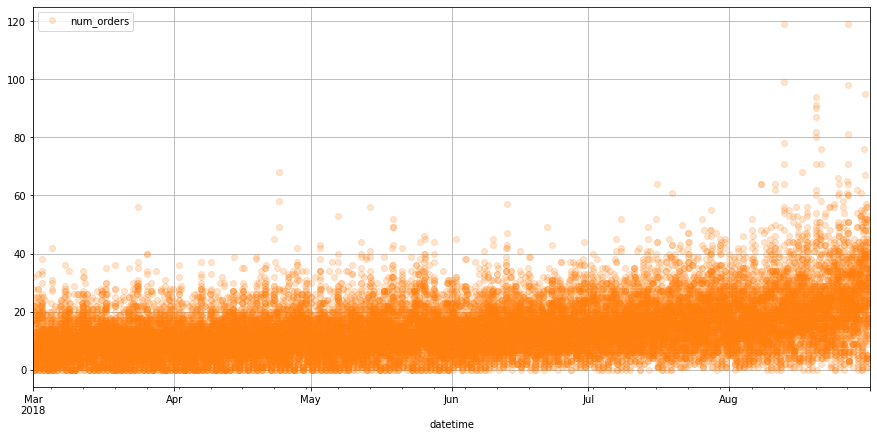

In [9]:
"""Постром график временного ряда"""

df = df['2018-03':'2018-08']
df.plot(grid=True, style='o',figsize=(15,7),alpha=0.2,color='tab:orange')
plt.show()

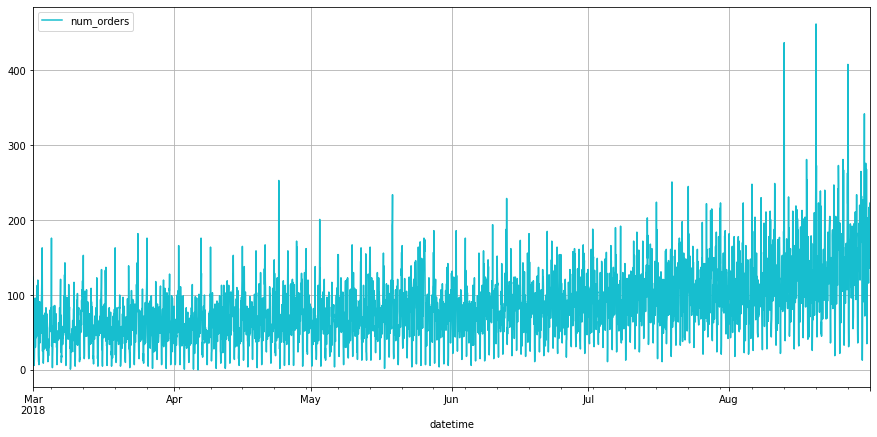

In [10]:
""" Постром график количества заказов с марта по август 2018 года. 
Выберим интервал в один час, по каждому — вычислим суммарное количество заказов"""

df = df['2018-03':'2018-08'].resample('1H').sum()
df.plot(figsize=(15,7), color='tab:cyan', grid = True)
plt.show()

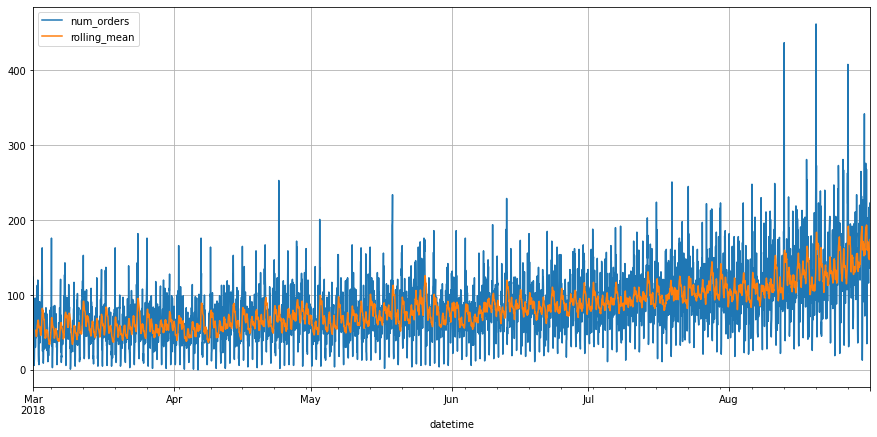

In [11]:
"""Чтобы во временном ряду снизить колебания, применим скользящее среднее"""

df.sort_index(inplace=True)
df = df['2018-03':'2018-08'].resample('1H').sum() 
df['rolling_mean'] = df.rolling(15).mean()
df.plot(figsize=(15,7), grid = True)
plt.show()

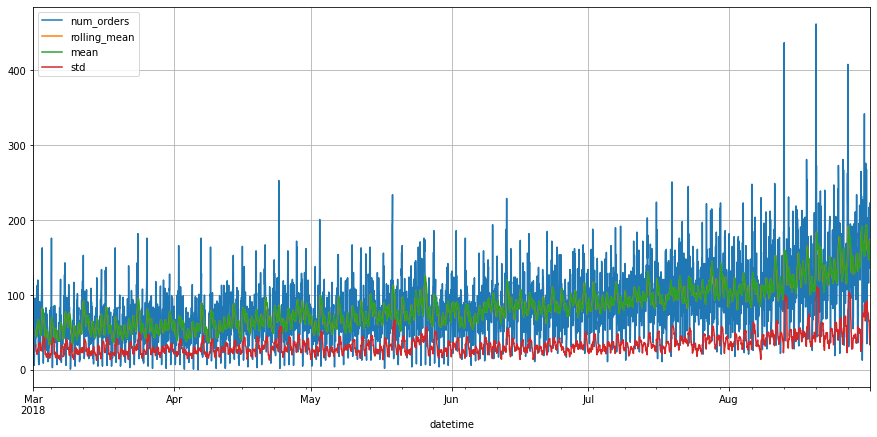

In [12]:
"""Вычислим разности временного ряда.
На графике изобразим скользящее среднее и скользящее стандартное отклонени"""

df['mean'] = df['num_orders'].shift().rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot(figsize=(15,7), grid = True)
plt.show()

**Вывод:**

- Среднее значение и стандартное отклонение со временем увеличиваются, значит временной ряд нестационарный
- Наблюдается тренд на увеличение количества заказов такси от месяца к месяцу

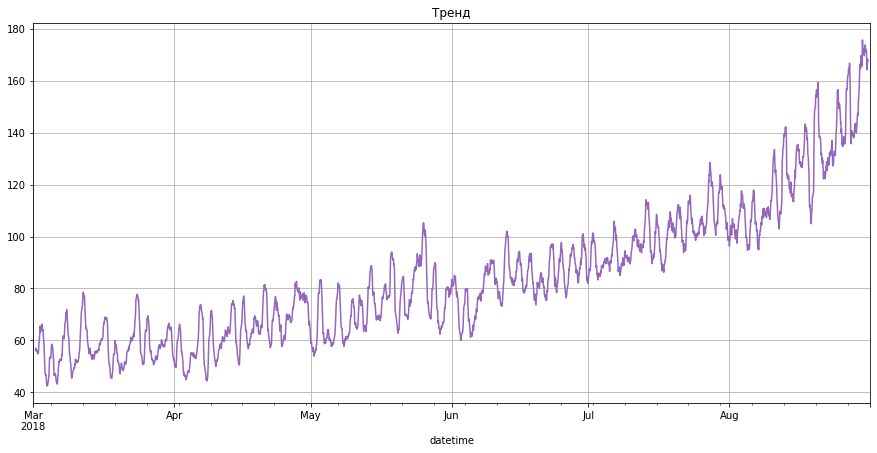

In [13]:
"""Разложим временной ряд на тренд,сезонную компоненту и остаток декомпозиции"""

decomposed = seasonal_decompose(df['num_orders']) 
decomposed.trend.plot(title='Тренд', figsize=(15,7), grid = True, color='tab:purple')
plt.show()

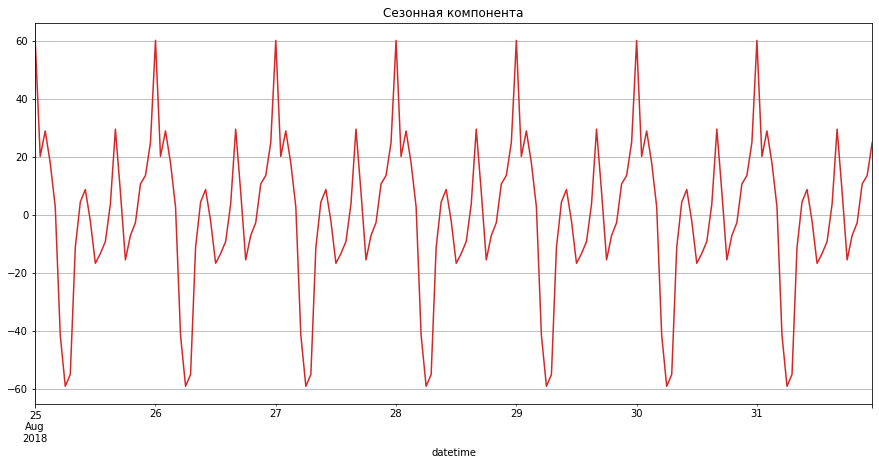

In [14]:
decomposed.seasonal.tail(24*7).plot(title='Сезонная компонента', figsize=(15,7),color='tab:red', grid = True)
plt.show()

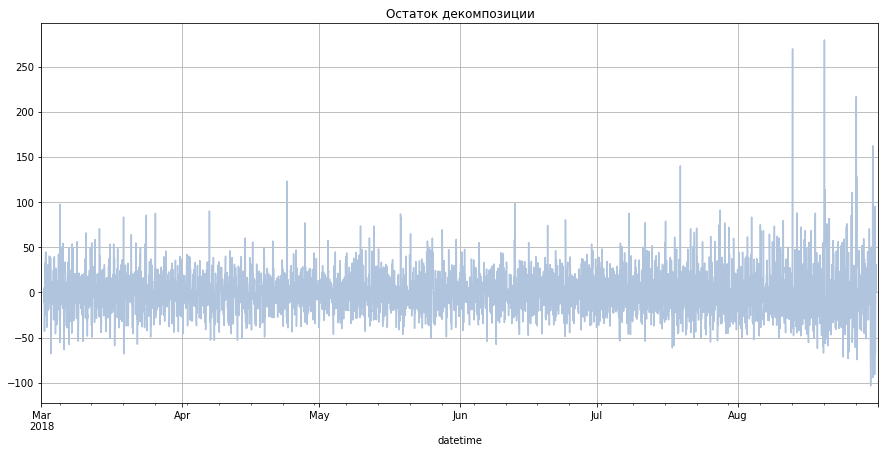

In [15]:
decomposed.resid.plot(title='Остаток декомпозиции', figsize=(15,7), color='lightsteelblue', grid = True)
plt.show()

**Вывод:**

Наш график в тренде!Сезонности и остатках.Тренд связан с временем года и можно сделать вывод, что самое часто время отпусков лето и чаще всего люди заказывают такси.Сезонность рассмотрим поближе.

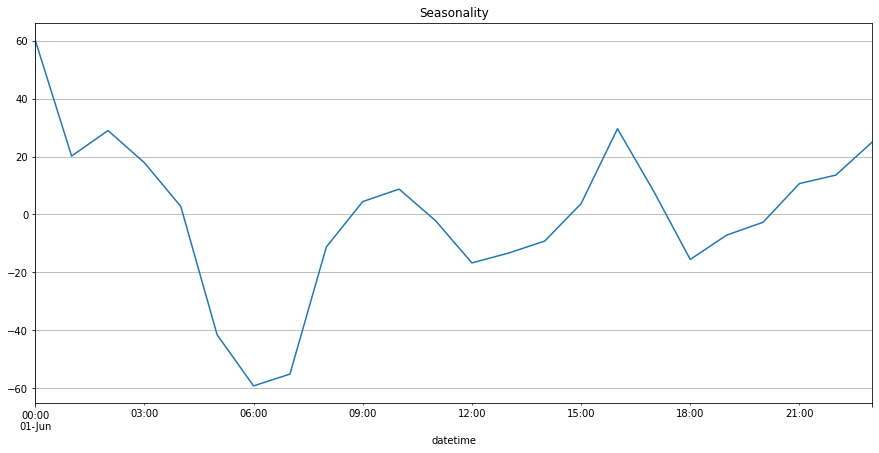

In [16]:
"""Рассмотрим сезонность в течение дня"""

decomposed = seasonal_decompose(df['num_orders'])
decomposed.seasonal['2018-06-01':'2018-06-01'].plot(title='Seasonality', figsize=(15,7), grid = True)
plt.show()

**Вывод:**

По графику можно сделать вывод, что в 6 часов утра самое невостребованное время, пик приходится на 12 часов ночи.Это может быть связано с тем,что вполне вероятно ночью прилетает меньше самолетов,да и пик на 12 часов ночи, т.к. с 00:00 до 6:00 не ходит общественный транспорт,такой как аэроэкспресс.

## Обучение моделей

In [17]:
"""Напишем функцию, чтобы прибавить к таблице 6 новых признаков: 
год, месяц, день, день недели,остающие значения и скользящее среднее"""

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)


make_features(df, 4, 4)
df

,num_orders,rolling_mean,mean,std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,,,,
2018-03-01 15:00:00,66,51.50,53.000000,27.357074,3,1,3,15,48.0,32.0,30.0,96.0
2018-03-01 16:00:00,43,44.00,49.133333,25.510969,3,1,3,16,66.0,48.0,32.0,30.0
2018-03-01 17:00:00,44,47.25,46.333333,24.581836,3,1,3,17,43.0,66.0,48.0,32.0
2018-03-01 18:00:00,73,50.25,44.533333,25.079872,3,1,3,18,44.0,43.0,66.0,48.0
2018-03-01 19:00:00,45,56.50,45.000000,25.073796,3,1,3,19,73.0,44.0,43.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,184.25,156.133333,57.917018,8,31,4,19,207.0,217.0,197.0,116.0
2018-08-31 20:00:00,154,189.25,147.333333,54.650578,8,31,4,20,136.0,207.0,217.0,197.0
2018-08-31 21:00:00,159,178.50,152.400000,43.955605,8,31,4,21,154.0,136.0,207.0,217.0


In [18]:
"""Сделаем тестовую выборку размером 10% от исходных данных"""

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [19]:
train.shape, train.index.min(), train.index.max()

((3960, 12),
 Timestamp('2018-03-01 15:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'))

In [20]:
test.shape, test.index.min(), test.index.max()

((441, 12),
 Timestamp('2018-08-13 15:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [21]:
features_train.shape, features_train.index.min(), features_train.index.max()

((3960, 11),
 Timestamp('2018-03-01 15:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'))

In [22]:
features_test.shape, features_test.index.min(), features_test.index.max()

((441, 11),
 Timestamp('2018-08-13 15:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [23]:
"""Напишем функцию для подбора моделей"""

def model_rmse(model, title):
    model = model
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print(title)
    print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)

## Тестирование моделей

In [24]:
%%time
model_rmse(LinearRegression(), 'LinearRegression')

LinearRegression
RMSE обучающей выборки: 30.45131966061354
RMSE тестовой выборки:  53.529698970643096
CPU times: user 8.52 ms, sys: 23.6 ms, total: 32.1 ms
Wall time: 10.3 ms


In [25]:
%%time
model_rmse(RandomForestRegressor(), 'RandomForestRegressor')

RandomForestRegressor
RMSE обучающей выборки: 8.00444734967614
RMSE тестовой выборки:  42.25780980563428
CPU times: user 2.21 s, sys: 46.6 ms, total: 2.26 s
Wall time: 2.32 s


In [26]:
%%time
model_rmse(LGBMRegressor(), 'LGBMRegressor')

LGBMRegressor
RMSE обучающей выборки: 13.764209779774644
RMSE тестовой выборки:  42.27913550376434
CPU times: user 3min 40s, sys: 1.49 s, total: 3min 42s
Wall time: 3min 44s


In [27]:
%%time
model_rmse(CatBoostRegressor(), 'CatBoostRegressor')

Learning rate set to 0.050888
0:	learn: 37.6363574	total: 49.9ms	remaining: 49.9s
1:	learn: 36.7571287	total: 52.5ms	remaining: 26.2s
2:	learn: 35.8992242	total: 54.9ms	remaining: 18.2s
3:	learn: 35.1598432	total: 57.1ms	remaining: 14.2s
4:	learn: 34.4636093	total: 59.5ms	remaining: 11.8s
5:	learn: 33.8636420	total: 61.9ms	remaining: 10.3s
6:	learn: 33.2976291	total: 64.4ms	remaining: 9.14s
7:	learn: 32.6381581	total: 66.8ms	remaining: 8.28s
8:	learn: 32.0402619	total: 69ms	remaining: 7.6s
9:	learn: 31.6335772	total: 71.5ms	remaining: 7.07s
10:	learn: 31.2007912	total: 73.8ms	remaining: 6.63s
11:	learn: 30.7235695	total: 76.1ms	remaining: 6.26s
12:	learn: 30.3272627	total: 78.4ms	remaining: 5.95s
13:	learn: 29.8731273	total: 80.8ms	remaining: 5.69s
14:	learn: 29.5221835	total: 83.1ms	remaining: 5.46s
15:	learn: 29.1881705	total: 85.4ms	remaining: 5.25s
16:	learn: 28.9042203	total: 87.8ms	remaining: 5.08s
17:	learn: 28.5408192	total: 90.1ms	remaining: 4.91s
18:	learn: 28.2247689	total: 

In [28]:
%%time
model_rmse(XGBRegressor(), 'XGBRegressor')

XGBRegressor
RMSE обучающей выборки: 6.842771403416029
RMSE тестовой выборки:  44.01041270462154
CPU times: user 4.55 s, sys: 25.3 ms, total: 4.58 s
Wall time: 4.55 s


In [38]:
results = {
    'Model' : ['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'XGBRegressor'],
    'RMSE обучающей выборки' :pd.Series([30.45, 8.0, 13.76, 12.22, 6.84]),
    'RMSE тестовой выборки' :pd.Series([53.53, 42.26, 42.28, 45.02, 44.01]),
    'Wall time, s': pd.Series([0.10, 2.32, 24.0, 3.34, 4.55]),
    }
display(pd.DataFrame(results))

,Model,RMSE обучающей выборки,RMSE тестовой выборки,"Wall time, s"
0,LinearRegression,30.45,53.53,0.10
1,RandomForestRegressor,8.00,42.26,2.32
2,LGBMRegressor,13.76,42.28,24.00
3,CatBoostRegressor,12.22,45.02,3.34
4,XGBRegressor,6.84,44.01,4.55


In [30]:
tss = TimeSeriesSplit(n_splits=5) # задаём число фолдов для кросс-валидации

No handles with labels found to put in legend.


Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
RMSE тестовой выборки  53.529698970643096
CPU times: user 496 ms, sys: 284 ms, total: 780 ms
Wall time: 770 ms


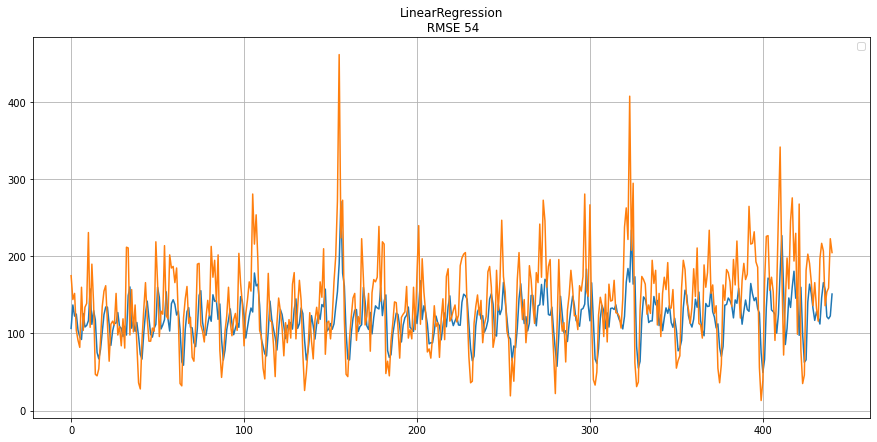

In [31]:
%%time

model = LinearRegression()
params = {
         'fit_intercept':[True,False],
          'normalize':[True,False], 
          'copy_X':[True, False]
         }
model = GridSearchCV(estimator=model, param_grid=params, cv=tss, n_jobs=-1)
model.fit(features_train, target_train)
mse = mean_squared_error(target_test, model.predict(features_test))
print('Лучшие гиперпараметры: ', model.best_params_)
print('RMSE тестовой выборки ', mse ** 0.5)
plt.figure(figsize=(15, 7))
plt.plot(model.predict(features_test))
plt.plot(target_test.values)
plt.legend(loc="best")
plt.title("LinearRegression\n RMSE {}".format(round(mse ** 0.5)))
plt.grid(True)

No handles with labels found to put in legend.


Лучшие гиперпараметры:  {'max_depth': 15, 'n_estimators': 101, 'random_state': 12345}
RMSE тестовой выборки  43.227743783379694
CPU times: user 16.2 s, sys: 77.1 ms, total: 16.3 s
Wall time: 16.3 s


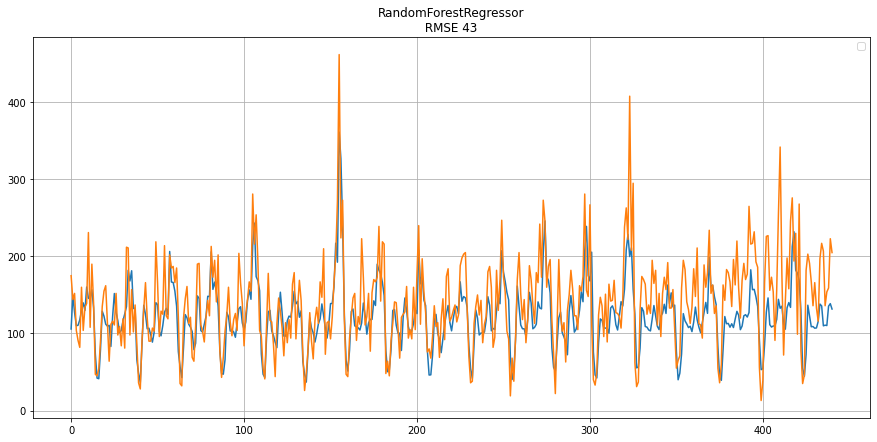

In [32]:
%%time

model = RandomForestRegressor()
params = {
         'n_estimators' : [50, 101, 10],
         'max_depth' : [5, 15, 2],
         'n_estimators' : [50, 101, 10],
         'random_state' : [12345] 
         }
model = GridSearchCV(estimator=model, param_grid=params, cv=tss, n_jobs=-1)
model.fit(features_train, target_train)
mse = mean_squared_error(target_test, model.predict(features_test))
print('Лучшие гиперпараметры: ', model.best_params_)
print('RMSE тестовой выборки ', mse ** 0.5)
plt.figure(figsize=(15, 7))
plt.plot(model.predict(features_test))
plt.plot(target_test.values)
plt.legend(loc="best")
plt.title("RandomForestRegressor\n RMSE {} ".format(round(mse ** 0.5)))
plt.grid(True)

No handles with labels found to put in legend.


Лучшие гиперпараметры:  {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 50, 'random_state': 12345}
RMSE тестовой выборки  43.551181156037025
CPU times: user 36.8 s, sys: 374 ms, total: 37.2 s
Wall time: 37.6 s


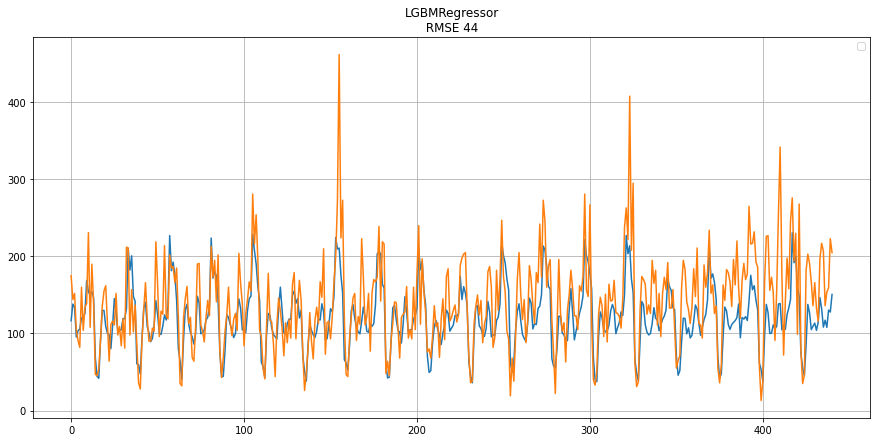

In [33]:
%%time

model = LGBMRegressor()
params = {
         'learning_rate': [0.03, 0.1],
         'max_depth': [5, 15, 2],
         'n_estimators': [50, 101, 10],
         'random_state': [12345] 
         }
model = GridSearchCV(estimator=model, param_grid=params, cv=tss, n_jobs=-1)
model.fit(features_train, target_train)
mse = mean_squared_error(target_test, model.predict(features_test))
print('Лучшие гиперпараметры: ', model.best_params_)
print('RMSE тестовой выборки ', mse ** 0.5)
plt.figure(figsize=(15, 7))
plt.plot(model.predict(features_test))
plt.plot(target_test.values)
plt.legend(loc="best")
plt.title("LGBMRegressor\n RMSE {} ".format(round(mse ** 0.5)))
plt.grid(True)

No handles with labels found to put in legend.


Лучшие гиперпараметры:  {'max_depth': 3, 'random_state': 12345}
RMSE тестовой выборки  46.641776054891935
CPU times: user 56 s, sys: 346 ms, total: 56.4 s
Wall time: 57.4 s


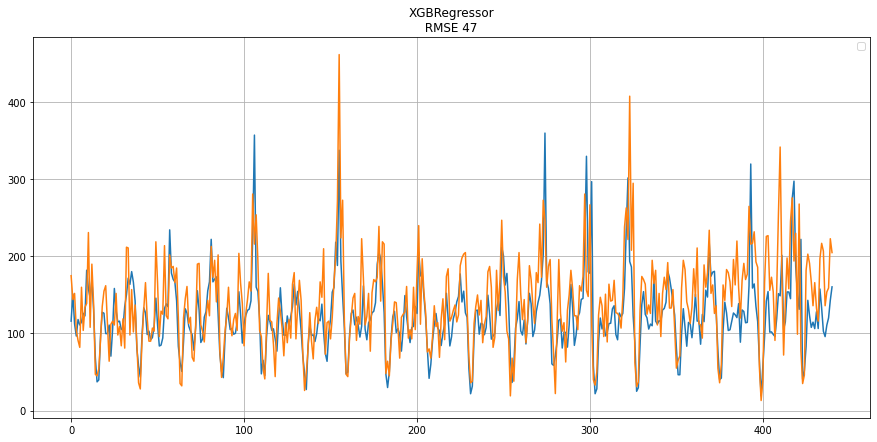

In [34]:
%%time

model = XGBRegressor()
params = {
        'max_depth': [3, 10], 
        'random_state': [12345]  
        }
model = GridSearchCV(estimator=model, param_grid=params, cv=tss, n_jobs=-1)
model.fit(features_train, target_train)
mse = mean_squared_error(target_test, model.predict(features_test))
print('Лучшие гиперпараметры: ', model.best_params_)
print('RMSE тестовой выборки ', mse ** 0.5)
plt.figure(figsize=(15, 7))
plt.plot(model.predict(features_test))
plt.plot(target_test.values)
plt.legend(loc="best")
plt.title("XGBRegressor\n RMSE {} ".format(round(mse ** 0.5)))
plt.grid(True)

No handles with labels found to put in legend.


Лучшие гиперпараметры:  {'max_depth': 5, 'verbose': 0}
RMSE тестовой выборки  44.45264273725767
CPU times: user 1min 29s, sys: 1.57 s, total: 1min 30s
Wall time: 1min 38s


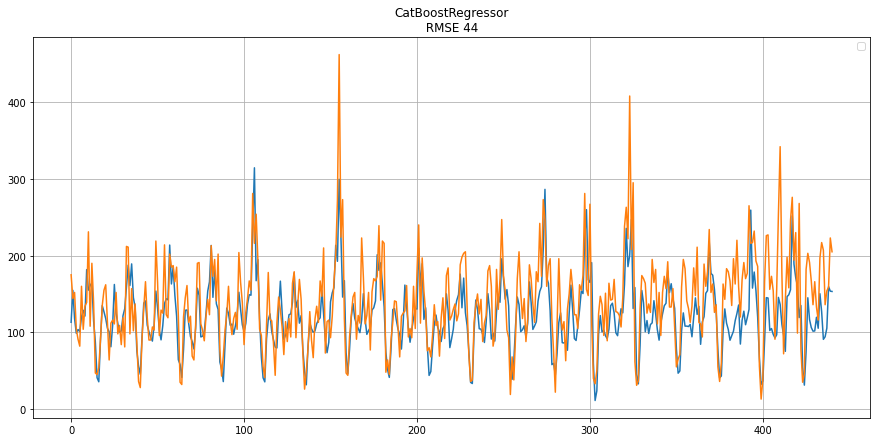

In [35]:
%%time

model = CatBoostRegressor()
params = {
        'verbose' : [0],
        'max_depth' : [5, 10]
         } 

model = GridSearchCV(estimator=model, param_grid=params, cv=tss, n_jobs=-1)
model.fit(features_train, target_train)
mse = mean_squared_error(target_test, model.predict(features_test))
print('Лучшие гиперпараметры: ', model.best_params_)
print('RMSE тестовой выборки ', mse ** 0.5)
plt.figure(figsize=(15, 7))
plt.plot(model.predict(features_test))
plt.plot(target_test.values)
plt.legend(loc="best")
plt.title("CatBoostRegressor\n RMSE {} ".format(round(mse ** 0.5)))
plt.grid(True)

In [37]:
results = {
    'Model' : ['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 'XGBRegressor','CatBoostRegressor'],
    'RMSE тестовой выборки' :pd.Series([53.53, 43.23, 43.55, 46.64, 44.45]),
    'Wall time, s': pd.Series([7.7, 16.3, 37.6, 57.4, 98.0]),
    }
display(pd.DataFrame(results))

,Model,RMSE тестовой выборки,"Wall time, s"
0,LinearRegression,53.53,7.7
1,RandomForestRegressor,43.23,16.3
2,LGBMRegressor,43.55,37.6
3,XGBRegressor,46.64,57.4
4,CatBoostRegressor,44.45,98.0


**Вывод:**

Мы провели анализ и подготовили данные для моделей. Обучили разные модели. Путем проверки обученных моделей на тестовых выборках, пришли к выводу, что модель RandomForestRegressor дает лучшие показатели RMSE.

## Вывод

Построили модель RandomForestRegressor для компания «Чётенькое такси»,которая будет привлекать водителей такси в период пиковой нагрузки в аэропортах. 